# T2D benchmark

In [28]:
import logging as log
log.getLogger().setLevel(log.INFO)

import takco

dataset = takco.evaluate.dataset.T2D(
    name='t2d-v1', version=1, resourcedir='resources', datadir='data',
    download = [
    'http://webdatacommons.org/webtables/tables_instance.tar.gz',
    'http://webdatacommons.org/webtables/entities_instance.tar.gz',
    'http://webdatacommons.org/webtables/classes_instance.csv',
    'http://webdatacommons.org/webtables/attributes_instance.tar.gz',
]
)

# dataset = takco.evaluate.dataset.T2D(
#     resourcedir='resources',
#     datadir='data',
#     tabledir = 'data/taipan/TAIPAN-Datasets-master/T2DStar/tables',
# #     entitydir = 'data/t2d-v2/instance',
#     classfile = 'data/t2d-v2/classes_GS.csv',
# #     propdir = 'data/t2d-v2/property',
#     keycolfile = 'data/taipan/TAIPAN-Datasets-master/T2DStar/subject_column.csv',
#     propdir = 'data/taipan/TAIPAN-Datasets-master/T2DStar/properties_t2d_format',
# )


takco.preview(dataset.get_annotated_tables_as_predictions())

INFO:root:Downloading http://webdatacommons.org/webtables/tables_instance.tar.gz to data/t2d-v1/tables_instance.tar.gz
INFO:root:Unpacking data/t2d-v1/tables_instance.tar.gz to data/t2d-v1/tables_instance
INFO:root:Downloading http://webdatacommons.org/webtables/entities_instance.tar.gz to data/t2d-v1/entities_instance.tar.gz
INFO:root:Unpacking data/t2d-v1/entities_instance.tar.gz to data/t2d-v1/entities_instance
INFO:root:Downloading http://webdatacommons.org/webtables/classes_instance.csv to data/t2d-v1/classes_instance.csv
INFO:root:Downloading http://webdatacommons.org/webtables/attributes_instance.tar.gz to data/t2d-v1/attributes_instance.tar.gz
INFO:root:Unpacking data/t2d-v1/attributes_instance.tar.gz to data/t2d-v1/attributes_instance
INFO:root:Read 233 tables from data/t2d-v1/tables_instance
INFO:root:Read 233 key cols from data/t2d-v1/attributes_instance
INFO:root:Read 233 prop files from data/t2d-v1/attributes_instance
INFO:root:Read 233 class tables from data/t2d-v1/classe

?,0,1,2
∈,Book,,
0,,author,
,title,author,source
,adventures of huckleberry finn,mark twain,ala [11]
,the adventures of super diaper baby,dav pilkey,ala [47]
,the adventures of tom sawyer,mark twain,ala
,alice series,phyllis reynolds naylor,ala [2]
,all the king's men,robert penn warren,rad
?,0,1,2
∈,,Newspaper,


In [39]:
searcher = takco.config.build('dbpedia_t2ksubset_es', load='resources/pipelines/t2d-v2-baseline.toml')
print(searcher)

# Test
with searcher:
    for rs in searcher.search_entities([('USA',{})]):
        print([r.uri for r in rs])

ElasticSearcher(index='dbpediasub-7', baseuri='http://dbpedia.org/resource/', propbaseuri='http://dbpedia.org/ontology/', es_kwargs={'hosts': ['bricks07'], 'timeout': 60}, parts=True, prop_uri={'type': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'}, prop_baseuri={'type': 'http://dbpedia.org/ontology/'}, typer=SimpleTyper(use_dateparser='dateutil'), stringmatch='jaccard')
['http://dbpedia.org/resource/United_States']


In [30]:
%%capture --no-display
from dask.distributed import Client
client = Client(address = 'tcp://192.168.62.207:8686')
client

Client Scheduler: tcp://192.168.62.207:8786 Dashboard: http://192.168.62.207:8787/status,Cluster Workers: 10 Cores: 20 Memory: 673.47 GB


In [43]:
%%time

baseline = takco.config.build('linker', load='resources/pipelines/t2d-v2-baseline.toml')

pred = takco.TableSet.link(
#     takco.DaskHashBag(takco.TableSet.dataset(dataset), client=client),
    takco.TableSet(list(takco.TableSet.dataset(dataset))[:10]),
    usecols = "keycol",
    linker = baseline,
)
pred.tables.persist()

report = pred.report(keycol_only=True, curve = True )

import pandas as pd
pd.DataFrame.from_dict( report.get('scores'), orient='index' )

CPU times: user 641 ms, sys: 33.6 ms, total: 675 ms
Wall time: 1.44 s


,precision,recall,f1-score,support,predictions
entities,0.27907,0.433735,0.339623,166,258


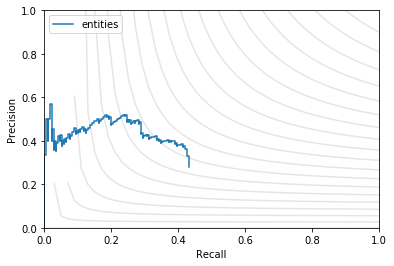

In [44]:
from takco.evaluate import pr_plot
pr_plot(report['curves'])

In [45]:
takco.preview( pred, nrows=None, ntables=25, hide_correct_rows=True )

?,0,1,2,3
∈,OfficeHolder ❓,,,
,Alexander Mackenzie,,,
,Arthur Meighen,,,
,Brian Mulroney 💡,,,
,Charles Tupper,,,
,Jean Chrétien,,,
,Joe Clark ❌ 💡,,,
,John A . Macdonald,,,
,John George Diefenbaker 💡,,,
,John Joseph Caldwell Abbott,,,
